#### Model and Predictions

In [1]:
# imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RepeatedKFold
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import make_scorer

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Input, Flatten, Conv2D, MaxPool2D
from keras.regularizers import l1, l2, l1_l2
from keras.callbacks import EarlyStopping
from keras.layers import SimpleRNN, LSTM, GRU, Dense
from keras import backend as K


In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
cd gdrive/My Drive

/content/gdrive/My Drive


In [9]:
df = pd.read_csv('data/etsy_shops_clean.csv')

In [10]:
df.head()

,seller_location,seller_join_date,sales_count,number_of_reviews,average_review_score,number_of_items
0,"Soorts-Hossegor, France",2017,14,2.0,4.0000,0
1,"Arizona, United States",2016,137,18.0,5.0000,15
2,"New York, United States",2012,13995,2087.0,4.9218,369
3,"Oklahoma, United States",2012,10,4.0,5.0000,12
4,"Ohio, United States",2019,16,3.0,5.0000,84


In [11]:
X = df.drop(columns = ['sales_count', 'seller_location'])
y = df['sales_count']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 22) #train test split the variables

**Null Model** 

In [13]:
# baseline performance is ~30 sales
mean_y_array = np.full_like(y_test, y_test.mean())
np.round(mean_squared_error(y_test, mean_y_array, squared = False), 2)

5892.69

In [14]:
r2_score(y_test, mean_y_array)

-2.08709827198561e-09

**Linear Regression**

In [15]:
pipe_lr = make_pipeline(StandardScaler(), LinearRegression()) #instantiate a pipe with LR

In [16]:
# fit the data
pipe_lr.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [17]:
pipe_lr.score(X_train, y_train)

0.8372224896457698

In [18]:
pipe_lr.score(X_test, y_test)

0.8760747464155161

In [19]:
# RMSE
np.round(mean_squared_error(y_test, pipe_lr.predict(X_test), squared = False), 2)

2074.4

**Gradient Boosting Regressor**

In [20]:
pipe_boost = make_pipeline(StandardScaler(), GradientBoostingRegressor())

In [21]:
pipe_boost.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                           criterion='friedman_mse', init=None,
                                           learning_rate=0.1, loss='ls',
                                           max_depth=3, max_features=None,
                                           max_leaf_nodes=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=1,
                                           min_samples_split=2,
                                           min_weight_fraction_leaf=0.0,
                                           n_estimators=100,
                                           n_iter_no_change=N

In [22]:
pipe_boost.score(X_train, y_train)

0.9462578208043686

In [23]:
pipe_boost.score(X_test, y_test)

0.9051384040803602

In [24]:
# RMSE
np.round(mean_squared_error(y_test, pipe_boost.predict(X_test), squared = False), 2)

1814.93

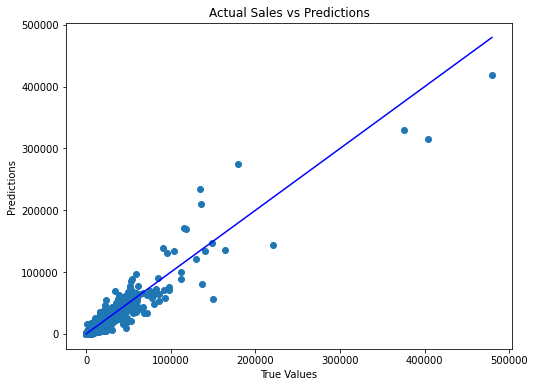

In [32]:
plt.figure(figsize = (8,6))
plt.scatter(y_test, pipe_boost.predict(X_test))
plt.xlabel('True Values', fontsize = 10)
plt.ylabel('Predictions', fontsize = 10) 
p1 = max(max(pipe_boost.predict(X_test)), max(y_test))
p2 = min(min(pipe_boost.predict(X_test)), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.title('Actual Sales vs Predictions');

**Random Forest Regressor**

In [25]:
pipe_forest = make_pipeline(StandardScaler(), RandomForestRegressor()) #instantiate a pipe with RF

In [26]:
# fit the data
pipe_forest.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomforestregressor',
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=None,
                                       max_features='auto', max_leaf_nodes=None,
                                       max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=100, n_jobs=None,
                                       oob_score=False, random_state=None,
                                       verbose=0, warm_start=False))],
         verbose=False)

In [ ]:
# score on the train data
pipe_forest.score(X_train, y_train)

0.9234733574866685

In [27]:
# score on the train data
pipe_forest.score(X_test, y_test)

0.9024858706829104

In [28]:
# RMSE
np.round(mean_squared_error(y_test, pipe_forest.predict(X_test), squared = False), 4)

1840.1252

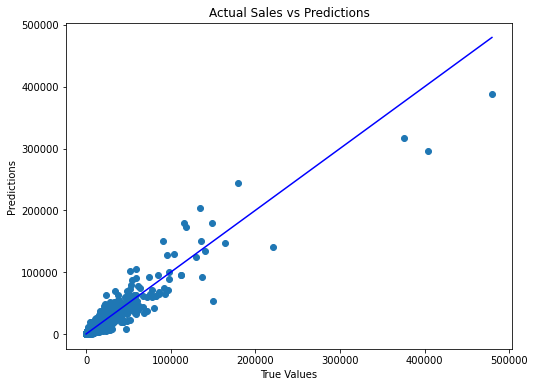

In [35]:
plt.figure(figsize = (8,6))
plt.scatter(y_test, pipe_forest.predict(X_test))
plt.xlabel('True Values', fontsize = 10)
plt.ylabel('Predictions', fontsize = 10) 
p1 = max(max(pipe_forest.predict(X_test)), max(y_test))
p2 = min(min(pipe_forest.predict(X_test)), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.title('Actual Sales vs Predictions');

In [64]:
# feature_importances = pd.DataFrame(pipe_forest.feature_importances_,
#                                    index = X_train.columns,
#                                     columns=['importance']).sort_values('importance', ascending=False)

In [74]:
!pip install eli5
import eli5


In [73]:
eli5.explain_weights(pipe_forest.named_steps['randomforestregressor'])

Weight,Feature
0.8545 ± 0.0823,x1
0.0846 ± 0.0826,x3
0.0340 ± 0.0207,x2
0.0268 ± 0.0247,x0


**Recursive Feature Selection**

In [72]:
# instantiate RFE
rfe_forest = RFE(estimator = RandomForestRegressor(), n_features_to_select = 10, step = 1)

In [75]:
# make pipeline
pipe_rfe_forest = make_pipeline(StandardScaler(), rfe_forest, RandomForestRegressor())

In [76]:
# fit train data into the pipeline
pipe_rfe_forest.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rfe',
                 RFE(estimator=RandomForestRegressor(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     criterion='mse',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2...
                 RandomForestRegressor(bo

In [77]:
# coefficient rankings 
rankings_forest = rfe_forest.ranking_

In [79]:
# construct a dataframe with coefficients
rfe_forest_df = pd.DataFrame({'rankings' : rankings_forest, 'names' : X.columns})

In [80]:
# display sorted values
rfe_forest_df.sort_values(by = 'rankings', inplace = True)
rfe_forest_df.head(10)

,rankings,names
0,1,seller_join_date
1,1,number_of_reviews
2,1,average_review_score
3,1,number_of_items


**SVR**

In [29]:
# start a pipe
pipe_svr = make_pipeline(StandardScaler(), SVR())

In [30]:
pipe_svr.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svr',
                 SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
                     gamma='scale', kernel='rbf', max_iter=-1, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [33]:
pipe_svr.score(X_train, y_train)

0.05992309088137526

In [34]:
pipe_svr.score(X_test, y_test)

0.04972526199675099

In [ ]:
# RMSE
np.round(mean_squared_error(y_test, pipe_svr.predict(X_test), squared = False), 2)

14.52

**Neural Networks**

In [36]:
# instantiate StandardScaler
sscaler = StandardScaler() 

In [37]:
X_train_scaled = sscaler.fit_transform(X_train) #scale X_train

In [38]:
X_test_scaled = sscaler.transform(X_test) #scale X_test

In [39]:
# build a network 
model = Sequential()
model.add(Dense(200, kernel_initializer='normal',input_dim = X_train_scaled.shape[1], activation='relu'))
model.add(Dense(256, kernel_initializer='normal',activation='relu'))
model.add(Dense(256, kernel_initializer='normal',activation='relu'))
model.add(Dense(256, kernel_initializer='normal',activation='relu'))
model.add(Dense(1, kernel_initializer='normal',activation='linear'))

In [40]:
# compile the model
model.compile(loss = 'mse', optimizer = 'adam', metrics = ['mse'])

In [41]:
# fit the data
history = model.fit( 
    X_train_scaled,
    y_train,
    validation_data = (X_test_scaled, y_test),
    epochs = 35,
    verbose = 0
)

In [42]:
# evaluate the model
nn_model = model.evaluate(X_test_scaled, y_test)

1321/1321 [==============================] - 2s 2ms/step - loss: 2546582.7500 - mse: 2546582.7500


In [43]:
# rmse of the model with regularization
np.round(np.sqrt(nn_model), 2)

array([1595.8, 1595.8])

In [44]:
predictions = model.predict(X_test_scaled) # make predictions

In [45]:
# r-squared score
r2_score(y_test, predictions)

0.9266617684416398

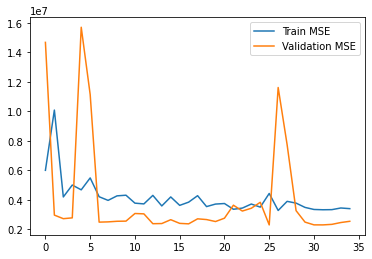

In [46]:
# plot Train and Validation MSE 
plt.plot(history.history['mse'], label = 'Train MSE')
plt.plot(history.history['val_mse'], label = 'Validation MSE')
plt.legend();

**Neural Network # 2**

In [47]:
# build a network 
model2 = Sequential()
model2.add(Dense(500, kernel_initializer='normal',input_dim = X_train_scaled.shape[1], activation='relu'))
model2.add(Dense(256, kernel_initializer='normal',activation='relu'))
model2.add(Dense(100, kernel_initializer='normal',activation='relu'))
model2.add(Dense(50, kernel_initializer='normal',activation='relu'))
model2.add(Dense(1, kernel_initializer='normal',activation='linear'))

In [48]:
# compile the model
model2.compile(loss = 'mse', optimizer = 'adam', metrics = ['mse'])

In [49]:
# fit the data
history2 = model2.fit( 
    X_train_scaled,
    y_train,
    validation_data = (X_test_scaled, y_test),
    epochs = 50,
    verbose = 0
)

In [50]:
# evaluate the model
nn_model2 = model2.evaluate(X_test_scaled, y_test)

1321/1321 [==============================] - 2s 2ms/step - loss: 2392004.0000 - mse: 2392004.0000


In [52]:
# rmse of the model with regularization
np.round(np.sqrt(nn_model2), 2)

array([1546.61, 1546.61])

In [54]:
predictions2 = model2.predict(X_test_scaled) # make predictions

In [55]:
# r-squared score
r2_score(y_test, predictions2)

0.9311133767585648

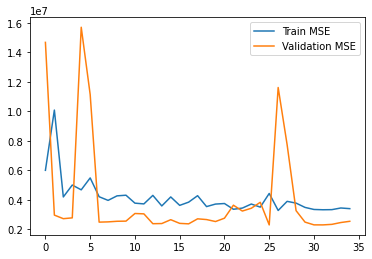

In [51]:
# plot Train and Validation MSE 
plt.plot(history.history['mse'], label = 'Train MSE')
plt.plot(history.history['val_mse'], label = 'Validation MSE')
plt.legend();